In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import emcee
import math
import corner
from tqdm import tqdm
from multiprocessing import Pool
import time
from tqdm import tqdm
from scipy.stats import mode

In [2]:
def svd_pure(data,ii):

    ft_M = data
    U, s, Vh = np.linalg.svd(ft_M)

    sigma = np.zeros(ft_M.shape)
    for i in range(min(ft_M.shape)):
        sigma[i,i] = s[i]

    cutmodes = ii
    sigma[:cutmodes] = 0
    sigma[cutmodes+1:] = 0
    ft_M_clean  = np.dot(np.dot(U[:, cutmodes:], sigma[cutmodes:]), Vh)# origin
    return ft_M_clean
def generate_noise(data):
    dnu = 0.2e6 #Hz
    dt = 10*60 #seconds
    rms = (data+100)/(dnu*dt*7*12*6)**0.5
    np.random.seed(111)
    noise = np.random.normal(0, rms, data.shape)*1.5
    return noise,data+noise, rms

def flat_signal(nu, A0 = -0.53, u = 78.1, sigma = 18.7,tau = 7):
 # flattening factor
    B = (4*(nu - u)**2/sigma**2)*(np.log10(-1/tau*(np.log10((1+math.e**(-tau))/2))))
    return A0*(1-math.e**(-tau*math.e**B))/(1-math.e**-tau)

In [3]:
def calculate_error_band(para):
    lines = []
    for ii in tqdm(range(para.shape[0])):
        lines.append(flat_signal(freq,*para[ii,-4:]))
    lines = np.array(lines)
    return np.std(lines,axis = 0)
def calculate_residual(para):
    lines = []
    for ii in tqdm(range(para.shape[0])):
        lines.append(spectrum-sp(freq,*para[ii]))
    lines = np.array(lines)
    return lines

In [4]:
fh_path = '/home/wangyue/aureum/flat_signal/sim_data/flat_signal_sim/flat_signal_sim_ion_2s.hdf5'
hf_fh = h5py.File(fh_path,'r')

start_freq = 50
freq = np.arange(start_freq,120,0.2)
fg_path = '/home/wangyue/aureum/flat_signal/sim_data/foreground_sim.hdf5'
hf_fg = h5py.File(fg_path,'r')

fg_only_T_ion = np.array(hf_fg['T_ion'])[:,(start_freq-30)*5:]
time_ion_data = np.array(hf_fh['T_ion'])[:,(start_freq-30)*5:]
time_noion_data = np.array(hf_fh['T_noion'])

time_ion_data.shape

(1008, 350)

In [5]:
ffd= []
#### time_noion_data is the data without noise
for ii in tqdm(range(fg_only_T_ion.shape[1])):
    xx = svd_pure(fg_only_T_ion,ii)

    ffd.append(xx)
    
ffd= np.array(ffd)
freq_model_ion = np.mean(ffd,axis = 1)

freq_fh_ion = np.mean(time_ion_data,axis=0)
ffd.shape,freq_model_ion.shape,freq_fh_ion.shape

100%|██████████| 350/350 [00:23<00:00, 15.00it/s]


((350, 1008, 350), (350, 350), (350,))

In [6]:
M0 = freq_model_ion[0]
M1 = freq_model_ion[1]
M2 = freq_model_ion[2]
M3 = freq_model_ion[3]
M4 = freq_model_ion[4]

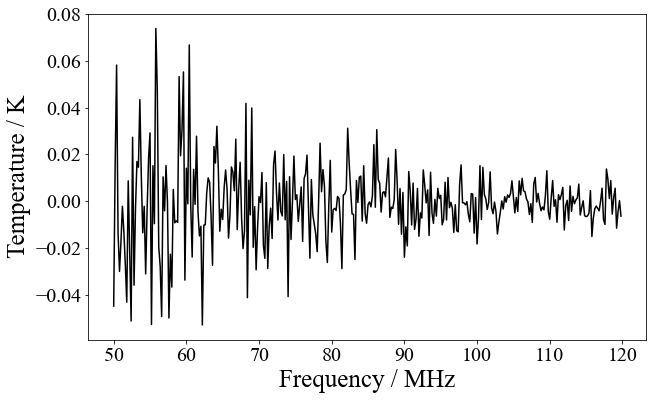

In [7]:
freq_noise,spectrum,rms = generate_noise(freq_fh_ion)
plt.figure(figsize=(10,6))
plt.plot(freq,freq_noise,'k')
# plt.title("Gaussian White Noise",fontname='Times New Roman',fontsize=25,weight = 'medium')
plt.xlabel("Frequency / MHz",fontname='Times New Roman',fontsize=25,weight='medium')
plt.ylabel("Temperature / K",fontname='Times New Roman',fontsize=25,weight='medium')
plt.xticks(fontsize=20,fontname='Times New Roman',weight='medium')
plt.yticks(fontsize=20,fontname='Times New Roman',weight='medium')
plt.show()

In [8]:

# Define your model function
def sp(nu, a0, a1, a2, a3, A0, u, sigma,tau):
    signal = flat_signal(nu,A0,u,sigma, tau)
    alpha = a0 * M0 + a1 * M1 + a2 * M2 + a3 * M3 
    return  alpha + signal


# Define log-likelihood function
def log_likelihood(params, freq, data):
    a0, a1, a2, a3, A0, u, sigma, tau = params
    model = sp(freq, a0, a1, a2, a3, A0, u, sigma, tau)
#     sigma2 = 0.1 ** 2  # Assuming some uncertainty
    return -0.5 * np.sum((data - model) ** 2  )/rms**2
# Define log-prior function (assuming flat priors for simplicity)
def log_prior(theta):
    a0, a1, a2, a3, A0, u, sigma, tau = theta
    # Define your prior distributions here
    # Example: uniform priors for a0, a1, a2, a3, a4
    if -10 < a0 < 50 and -15 < a1 < 50 and \
        -100 < a2 < 30 and -100 < a3 < 50 and \
        -0.8 < A0 < -0. and 65 < u < 90 and \
        10< sigma < 30 and 0 < tau < 12:
        return 0
    return -np.inf

# Define log-posterior function
def log_posterior(params, freq, data):
    lp = log_prior(params)

    return lp + log_likelihood(params, freq, data)


# Initial parameter guesses
# initial = np.array([2.32, 9.87, -11.09, 5.17, -1.24,0.12,-0.51, 78.1, 18.7])
# initial = np.array([2,  0, 0,  0, -0.0 ,0,-0.45,  78.7,  18.7])
initial = np.array([0, 0, -0, 0, -0.5,  78.1,18.6,7])


# Set up the sampler
ndim = len(initial)
nwalkers = 1500
nsteps = 7000
nprocess = 20
with Pool(nprocess) as pool:
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(freq, spectrum),pool = pool)

    # Initialize walkers
    p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
    # print(p0.shape)
    # Run the MCMC sampler
    print("Running MCMC ......")
    start = time.time()
    sampler.run_mcmc(initial_state=p0, nsteps=nsteps)
    end = time.time()
    cost_time = end - start
print("Took {0:.1f} seconds".format(cost_time))
# Extract the samples
samples = sampler.get_chain(discard=2000, thin=15, flat=True)


Running MCMC ......
Took 337.8 seconds


In [9]:
condition = samples[:,-1] < 100
filtered_data = samples[condition]

print("Original shape:", samples.shape)
print("Filtered shape:", filtered_data.shape)

Best_fit_para = np.mean(samples,axis = 0)

Best_fit_para

Original shape: (499500, 8)
Filtered shape: (499500, 8)


array([ 0.99754791,  0.49290996, -1.74636094,  1.0847029 , -0.52311952,
       78.12926824, 18.71412175,  6.83052662])

In [10]:
a0_samples, a1_samples, a2_samples, a3_samples,  A0_samples, u_samples, sigma_samples,tau_samples = samples[:, :].T

true_values = np.average(a0_samples), np.average(a1_samples), np.average(a2_samples), np.average(a3_samples), np.average(A0_samples),np.average(u_samples), np.average(sigma_samples), np.average(tau_samples)

true_values

(0.9975479106717005,
 0.49290996281876204,
 -1.7463609393124924,
 1.084702902590398,
 -0.5231195231877047,
 78.12926823962692,
 18.714121748995687,
 6.830526624323714)

In [11]:
best_parameter = []
for ii in tqdm(range(ndim)):
    values, counts = np.unique(filtered_data[:,ii], return_counts=True)
    best_parameter.append(values[np.argmax(counts)])
#     best_parameter.append(mode(filtered_data[:,ii],keepdims=True).mode[0])
best_parameter = np.array(best_parameter)
print(f"The parameter value with the highest density is: {best_parameter}")
# Best_fit_para[-1] = best_parameter[-1]

100%|██████████| 9/9 [00:00<00:00, 22.57it/s]

The parameter value with the highest density is: [   0.99753896    0.43074225   -4.89549387    0.73218471 -104.508964
   -0.56738715   77.88882437   17.99411972    5.42942598]


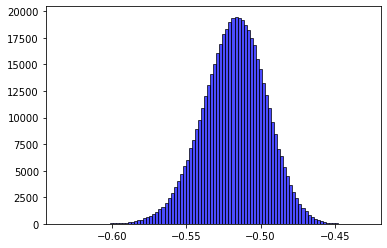

In [12]:
num_bins = 100
hist, bin_edges = np.histogram(filtered_data[:,-4], bins=num_bins)
plt.hist(filtered_data[:,-4], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.show()

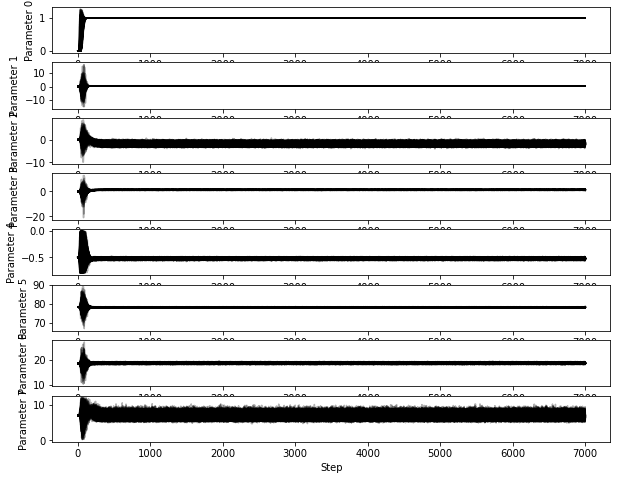

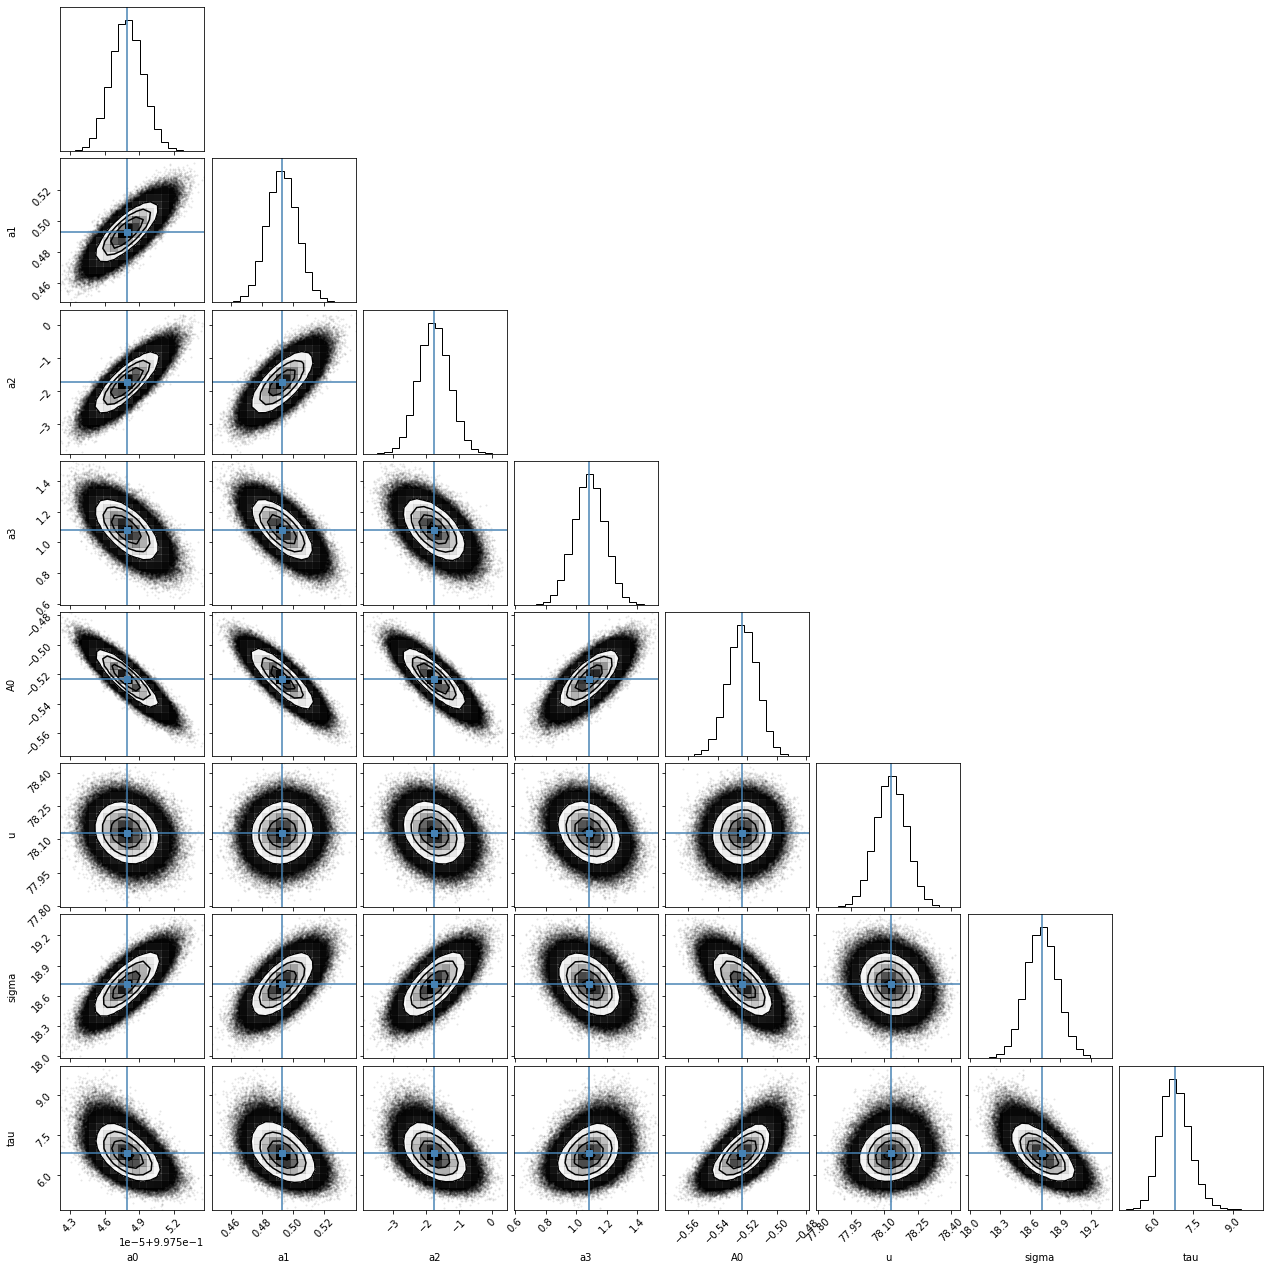

In [12]:
# Flatten the samples
flat_samples = samples

# Plot trace plots
plt.figure(figsize=(10, 8))
for i in range(ndim):
    plt.subplot(ndim, 1, i + 1)
    plt.plot(sampler.get_chain()[:, :, i], color='k', alpha=0.3)
    plt.ylabel(f'Parameter {i}')

plt.xlabel('Step')
plt.show()

# Plot corner plot
labels = ["a0", "a1", "a2", "a3", "A0", "u", "sigma", "tau"]
corner.corner(flat_samples, labels=labels, truths=true_values)
plt.show()


In [13]:
lh1 = np.mean(log_likelihood(initial,freq,spectrum))
lh2 = np.mean(log_likelihood(Best_fit_para,freq,spectrum))
print(lh1,initial,lh2,Best_fit_para)

-31825851087728.355 [ 0.   0.   0.   0.  -0.5 78.1 18.6  7. ] -1122.980625438835 [ 0.99754791  0.49290996 -1.74636094  1.0847029  -0.52311952 78.12926824
 18.71412175  6.83052662]


[ 0.99754791  0.49290996 -1.74636094  1.0847029  -0.52311952 78.12926824
 18.71412175  6.83052662]


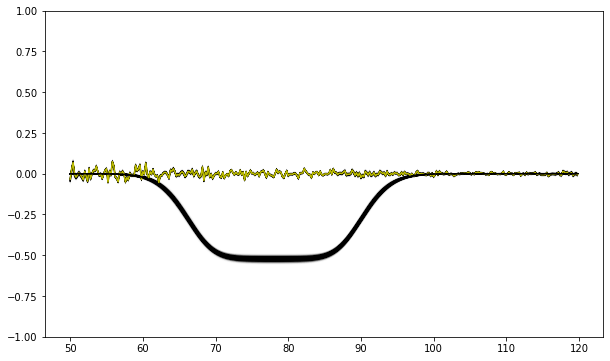

In [14]:
# Posterior predictive check
plt.figure(figsize=(10, 6))
for i in range(1000):
    index = np.random.randint(filtered_data.shape[0])
    # Randomly choose a set of parameters from the posterior samples
    random_params = filtered_data[index]
#     print(random_params)
    model = flat_signal(freq,random_params[-4],random_params[-3],random_params[-2],random_params[-1])
    residual = spectrum-sp(freq, *random_params)
    if -1<random_params[-4]<0 :
        plt.plot(freq, model, color='k', alpha=0.01)
        plt.plot(freq, residual, color='k', alpha=0.003)
#     print(index)
plt.ylim(-1,1)
plt.plot(freq,freq_noise, color='k', alpha=1 )
plt.plot(freq,spectrum-sp(freq,*Best_fit_para), color='y', alpha=1 )
plt.plot(freq,flat_signal(freq,*Best_fit_para[-4:]), color='k', alpha=1)
plt.plot(freq,flat_signal(freq,-0.53,78.1,18.7,7), 'k--', alpha=1)
print(Best_fit_para)

100%|██████████| 499500/499500 [00:24<00:00, 20215.33it/s]


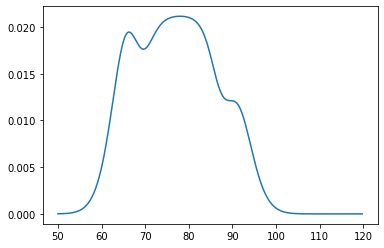

In [16]:
error_band = calculate_error_band(filtered_data)
plt.plot(freq,error_band)

In [17]:
def create_subplot_grid(rows, cols):
    # 创建一个新的图形
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    # 调整子图之间的间距
    plt.tight_layout()
    
#     plt.xlim(30,120)
    return fig, axes
linestyle = ['-','-.','--',':','-','-.','--',':']

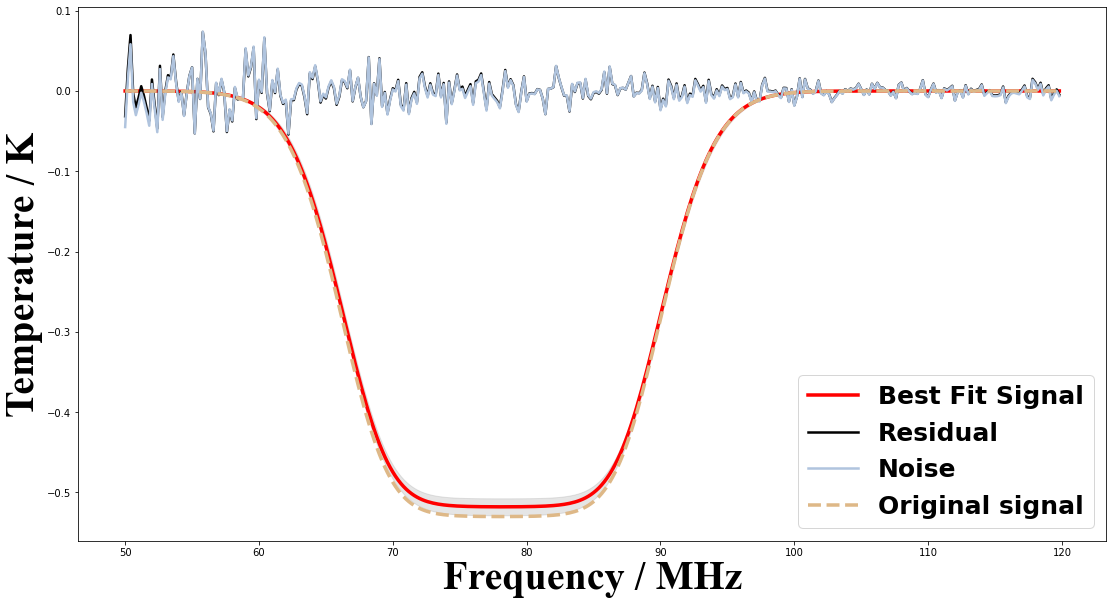

In [18]:
mean_value = flat_signal(freq,*Best_fit_para[-4:])

# Identify data points within 1 standard deviation
lower_bound = mean_value - 0.5*error_band
upper_bound = mean_value + 0.5*error_band

# 调用函数创建一个 2x3 的 subplot 网格
fig, axes = create_subplot_grid(1,1)
# axes[0, 0].plot(x_data, y_data)  # x_data 和 y_data 是你的数据
plt.subplots_adjust(wspace=0.12, hspace=0.1)
# plt.xticks(fontsize=18,weight = 'medium')
# plt.yticks(fontsize=18,weight = 'medium')
# 可以添加标题、标签等其他自定义
axes.set_ylabel('Temperature / K',fontname='Times New Roman',fontsize=40,weight = 'semibold')
axes.set_xlabel('Frequency / MHz',fontname='Times New Roman',fontsize=40,weight = 'semibold')

# axes[0, 0].text(-0.2, -0.2, 'Model-based SVD Template Fit', ha='center', va='center',rotation='vertical', fontsize=20,fontname='Times New Roman')
# axes[0, 0].text(-0.2, -1, 'Logarithmic Polynomial Fit', ha='center', va='center',rotation='vertical', fontsize=20,fontname='Times New Roman')
# fig.text(0.05, 0.5, 'Common Y-axis Label', va='center', rotation='vertical')
axes.plot(freq,flat_signal(freq,*Best_fit_para[-4:]),'r',label='Best Fit Signal',linewidth=3.5)
axes.plot(freq,spectrum-sp(freq,*Best_fit_para),'k',label='Residual',linewidth=2.5)
axes.plot(freq,freq_noise ,'#B0C4DE',label='Noise',linestyle = '-',linewidth=2.5)
axes.plot(freq,flat_signal(freq),'#DEB887',linestyle = '--',label='Original signal',linewidth=3.5)
plt.fill_between(freq, lower_bound, upper_bound, color='gray', alpha=0.2)

# axes.set_xlim(start_freq,120)

axes.legend(prop={'size':25,'weight':'semibold'},ncol=1)

In [20]:
fit_data_path = '/home/wangyue/aureum/flat_signal/msvdF_edgesS/fit_collection.hdf5'
hf_fitdata = h5py.File(fit_data_path,'a')
hf_fitdata.create_dataset('2s_residual', data=spectrum-sp(freq,*Best_fit_para))
hf_fitdata.create_dataset('2s_fitdata', data=Best_fit_para[-4:])
hf_fitdata.create_dataset('2s_noise', data=freq_noise)
hf_fitdata.create_dataset('2s_low_bound', data=lower_bound)
hf_fitdata.create_dataset('2s_up_bound', data=upper_bound)

hf_fitdata.close()